## Bank Churn Prediction

### Objective:

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

**Context:** 

Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

**Data Description:**

The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 
distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.
Link to the Kaggle project site:https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

**Data Dictionary:**

- RowNumber: Row number.
- CustomerId: Unique identification key for different customers.
- Surname: Surname of the customer
- Credit Score: Credit score is a measure of an individual's ability to pay back the borrowed amount. It is the numerical representation of their creditworthiness. A credit score is a 3-digit number that falls in the range of 300-900, 900 being the highest.
- Geography: The country to which the customer belongs.
- Gender: The gender of the customer.
- Age: Age of the customer.
- Tenure: The period of time a customer has been associated with the bank.
- Balance: The account balance (the amount of money deposited in the bank account) of the customer.
- NumOfProducts: How many accounts, bank account affiliated products the person has.
- HasCrCard: Does the customer have a credit card through the bank?
- IsActiveMember: Subjective, but for the concept
- EstimatedSalary: Estimated salary of the customer.
- Exited: Did they leave the bank after all?

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score,average_precision_score, confusion_matrix,
                             average_precision_score, precision_score, recall_score, roc_auc_score)
from mlxtend.plotting import plot_confusion_matrix

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

# Using Tensorflow Keras instead of the original Keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

# import io
# import requests

# Supressing the warning messages
import warnings
warnings.filterwarnings('ignore')

import os
import matplotlib.pyplot as plt
import seaborn as sns#visualization
sns.set(palette="Set2")
sns.set(style="ticks", color_codes=True)
import matplotlib.ticker as mtick # For specifying the axes tick format 
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

/Users/olivertang/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/olivertang/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/olivertang/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/olivertang/opt/anaconda3/lib/python3.7/site-pack

In [2]:
# !pip install tensorflow==2.0.0

In [3]:
import tensorflow as tf
tf.__version__

'1.14.0'

In [4]:
#Import dataset into and display head of your dataset

churn = pd.read_csv('bank.csv')
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Some of the attributes have almost no impact into our results such as Surname,CustomerId and RowNumber as long as we have an index(counts) it will serve as an ID.

In [5]:
#drop unnecessary attributes and display new dataset
churn = churn.drop(["RowNumber","CustomerId","Surname"], axis =1)

I've removed "RowNumber","CustomerId","Surname" columns as these have absolutely no impact on the outcome. However, please note that it wasn't necessary to do this because the neural network will automatically work this out, but removing them will save computational power.

In [6]:
#Describe how big is out dataset helps to understand how big will be our analysis and requirements.
print("Rows : ",churn.shape[0])
print("Columns  : ",churn.shape[1])

Rows :  10000
Columns  :  11


In [7]:
#I check if there is any NaN values that can bring biased scenario, all column attributes should return false to verify this 
churn.isnull().any()

CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

No Null Values - Beautiful!

In [8]:
#count our unique values without duplication of same figure

print ("\nUnique values :  \n",churn.nunique())


Unique values :  
 CreditScore         460
Geography             3
Gender                2
Age                  70
Tenure               11
Balance            6382
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
EstimatedSalary    9999
Exited                2
dtype: int64


How huge are our attributes? in the meantime it is quite easier to spot that Geography,Gender,HasCrCard and IsActiveMember are categorical attributes that can corresponds to (yes/no) or 1/0 to define its state. so the rest of the attributes should be continuous attributes.

In [9]:
#what are our data types
churn.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [10]:
#Mean=> the are a lot of average calculations in statistics so i used mean the check the average possibility of attributtes to impact the situation
churn.groupby(['Exited']).mean()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
Exited,,,,,,,,
0,651.853196,37.408389,5.033279,72745.296779,1.544267,0.707146,0.554565,99738.391772
1,645.351497,44.837997,4.932744,91108.539337,1.475209,0.699067,0.360825,101465.677531


The difference between Exited '1' and un Exited '0' is not much and can't draw any conclusions from. 
Note that:

- Customers with low creditscore tend to churn,reasonable!
- On average older customers are the most to churn,questionable?
- Customers with high balance are churning probably they are getting attracted by other banks offer to raise the wealth and this corresponds with their estimatedsalary also
- Tenure,creditcard and being active mean are not explicitly helping in this case to hightlight anything big

In [11]:
churn.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


As for features with numerical datatypes, we analyze their statistical distributions (count, mean, standard deviation, median, etc). This also help us to easily detect outliers (ex: if the maximum value on the age column was 200, that would easily mark the presence of outliers in our dataset).

## Visualizing the Distributions

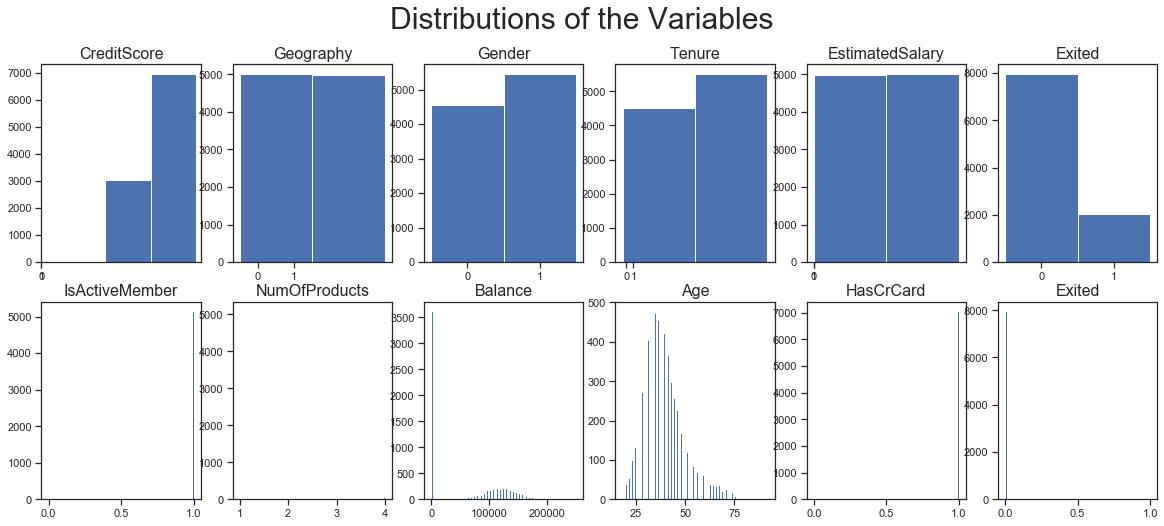

In [12]:
list_binary = [0,1,2,4,9,10]
list_normal = [3,5,6,7,8,11]
order = [0,1,2,4,9,10,8,6,5,3,7,10]

fig=plt.figure(figsize=(20,8))
for i in range(len(order)):
    xi = churn.values[:,order[i]]
    ax1 = fig.add_subplot(2,len(order)/2,i+1)
    plt.title(list(churn)[order[i]],fontsize=16)
    if i<6:
        plt.hist(xi,2)
        plt.xticks([0.25,0.75], np.arange(0, 2, 1))
    else:
        plt.hist(xi,100)
plt.suptitle('Distributions of the Variables',fontsize=30)
plt.show()

In the distributions above several types of behaviour can be seen:

- Some of the categorical variables follow a Berouilli distribution: Geography, IsMale, HasCrCard and IsActiveMember.
- Three of them are also categorical, but polytomous ones: NumOfProducts, Tenure and Age. While the latter follows a distribution similar to a lognormal, Tenure tends to be more uniform and NumOfProducts decays sharply for high values.
- The remaining variables are continuous. CreditScore and Balance are normally distributed and EstimatedSalary is almost uniformly distributed.

Note that the distribution won't change whenever we consider the normalized case.

## Encoding categorical data

Before exploring deep our dataset we can see attributes correlation with churn as we have seen that mean results are not so informative, so i first change dummies varibles which are Geography and Gender in our dataset so that we can get to define correlation of attributes to churn way easy.

In [13]:
# # Encoding categorical data
# #Let's convert all the categorical variables into dummy variables
df = pd.get_dummies(churn)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


## Exploratory Data Analysis

Here our main interest is to get an understanding as to how the given attributes relate too the 'Exit' status

Note: Exited will always play the role of a target

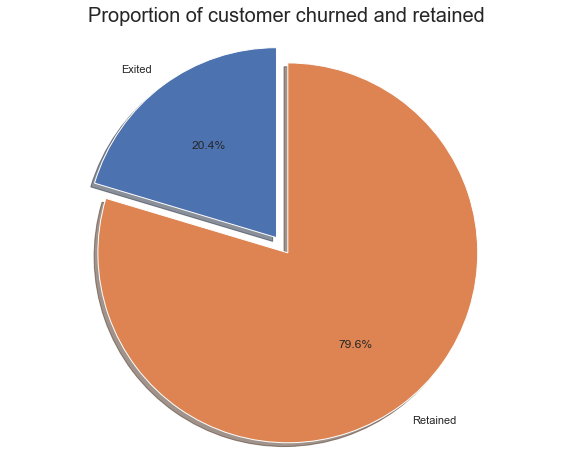

In [14]:
labels = 'Exited', 'Retained'
sizes = [churn.Exited[churn['Exited']==1].count(), churn.Exited[churn['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

So about 20% of the customers have churned. So the baseline model could be to predict that 20% of the customers will churn. Given 20% is a small number, we need to ensure that the chosen model does predict with great accuracy this 20% as it is of interest to the bank to identify and keep this bunch as opposed to accurately predicting the customers that are retained.

In [15]:
churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Valuable Information about Customers

In [16]:
# Defining X and Y
churnX = churn.iloc[:,:9]
churnY = churn.iloc[:,10]

In [17]:
lost_savings = churn.loc[churnY ==1, 'Balance'].sum()
print(lost_savings)

185588094.63


An exploration of the qualitative information that this dataset bears is also essetial. In order to do so, we will plot pie charts, bar plots and box plots of different variables, which will give us some understanding about what differences might be present between customerms.

**How much money has been lost due to customers leaving the institution?**

To put the problem into perspective, we only need to hear a number: 185.588.095€. That is the total amount of money lost due to the 2037 customers leaving the institution. Almost 200 million €, a daunting number, that more than justifies this work.

### Correlation plot of each feature

Now that we know a bit more about our customers, let's find the relations between the variables that describe them.

Finding an appropiate measure for the correlation of the variables is not an easy task, since we have to handle both categorical and continuous variables. The main problem comes because the usual Pearson Correlation becomes misleading when the pairs of variables are away from bivariate normality (like it is clearly our case).

Other alternative statistics may be more suitable for this problem, like discretizing all the continuous variables in finite bins and calculating the mutual information, which is basically a measure of how good can we predict a distribution knowing another one.

However, since the variables are standarized and the results are still somewhat meaninful (with a cautious interpretation), we will still use the classical correlation matrix.

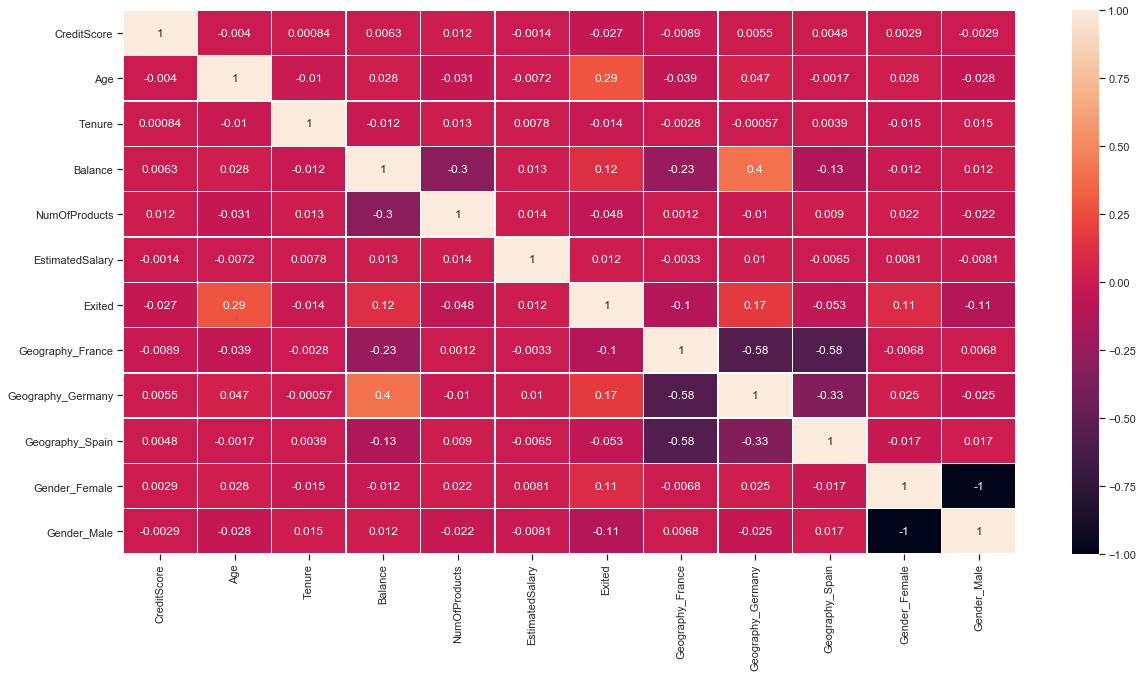

In [18]:
plt.figure(figsize = (20,10))
sns.heatmap((df.loc[:, ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary','Exited','Geography_France','Geography_Germany','Geography_Spain','Gender_Female','Gender_Male']]).corr(),
            annot=True,linewidths=.5);

The results of the correlation matrix only reinforce what we expected from Correlation between variables is pretty low in general (even when the variables that were not studied in the previous section are considered). However, it is important to remark some tendencies seen:

- Being german is highly correlated with having a high account balance.
- Germans are more likely to leave the bank than any other nationality.
- Women generally leave the institution at a higher rate.
- The churn (Exited variable) is correlated with the age and the account balance, while negatively correlated with being an active member.


Other trends from the heatmap visualization:

All features have a weak or strong correlation with the target (Thus we are considering all of them for our model)
Age, Balance, NumOfProducts, IsActiveMember, CreditScore are the features with significant correlation.

In [19]:
# Passing labels and values
lab = churn["Exited"].value_counts().keys().tolist()
val = churn["Exited"].value_counts().values.tolist()

trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'royalblue' ,'lime'],
                             line = dict(color = "white",
                                         width =  0.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .2
              )
layout = go.Layout(dict(title = "Customer churn",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

**20.4 Exited, 79.6% un Exited** This is a loss over a certain time yet there is no clear factor for churning maybe it is the nature of the business better be alert. but also it gives hope because the default test dataset is always 25% which will help to punish gradually.



**Head to Head attributes relations**

Categotical attributes and Continuous attributes on impacting Exited, here is not about the counts but a specifically churned and unchurned vs the service.

Text(0, 0.5, 'count')

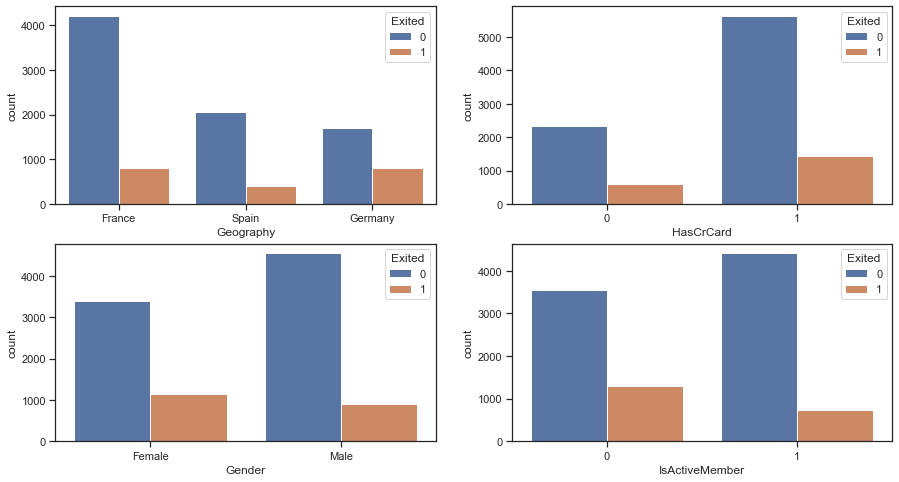

In [20]:
#Categorical attirbutes churn rate
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
sns.countplot(x= churn.Geography, hue = 'Exited' ,data=churn, ax =axs[0][0])
sns.countplot(x=churn.Gender, hue = 'Exited' ,data=churn, ax=axs[1][0])
sns.countplot(x=churn.HasCrCard, hue = 'Exited' ,data=churn, ax=axs[0][1])
sns.countplot(x=churn.IsActiveMember, hue = 'Exited' ,data=churn, ax=axs[1][1])
plt.ylabel('count')

**What do the Categorical attributes Highlight:**

We note the following:

- Majority of the data is from persons from France. However, the proportion of churned customers is with inversely related to the population of customers alluding to the bank possibly having a problem (maybe not enough customer service resources allocated) in the areas where it has fewer clients.

- The proportion of female customers churning is also greater than that of male customers

- Interestingly, majority of the customers that churned are those with credit cards. Given that majority of the customers have credit cards could prove this to be just a coincidence.

- Unsurprisingly the inactive members have a greater churn. Worryingly is that the overall proportion of inactive mebers is quite high suggesting that the bank may need a program implemented to turn this group to active customers as this will definately have a positive impact on the customer churn.

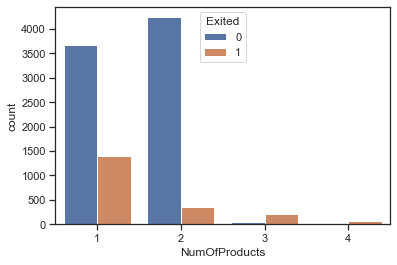

In [21]:
p = sns.countplot(data=churn, x = 'NumOfProducts', hue = 'Exited')

Customer with 3 or 4 products are higher chances to Churn

**Pivot table for Geography and Gender**

In [22]:
# Creating a pivot table demonstrating the percentile
# Of different genders and geographical regions in exiting the bank 
visualization_1 = churn.pivot_table("Exited", index="Gender", columns="Geography")
visualization_1

Geography,France,Germany,Spain
Gender,,,
Female,0.203450,0.375524,0.212121
Male,0.127134,0.278116,0.131124


From the table above, we can easily detect the following trends:

- Many females have exited the bank than males in all regions represented in the Dataset
- Germany is the country with many bank churns

However, though these features (Geography and Gender) might correlate with the target column, it is better to drop them from our model to preserve the universality of our prediction model (not only predicting values from Germany, France and Spain).

**Continous attributes impact on churn rate**

For continuous attributes I will have to normalize its values in order to compare its churn. For example, it won't be possible to plot Balance and age in the same plot yet they have very different figures.

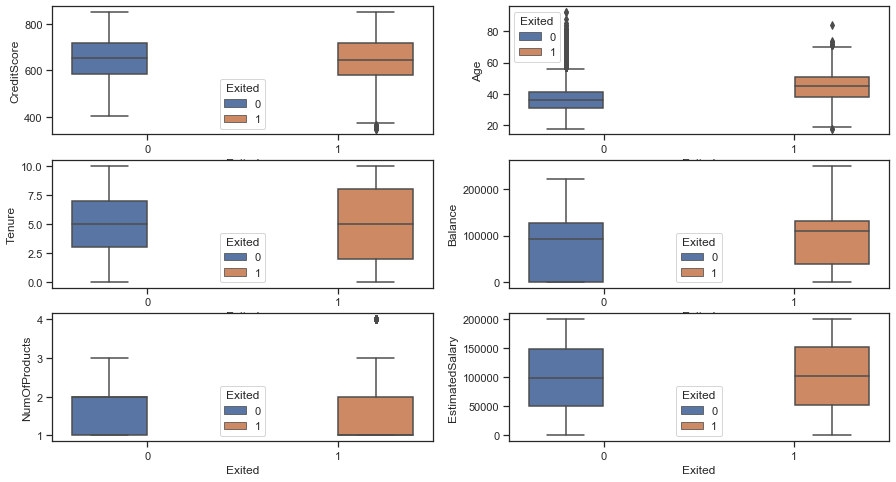

In [23]:
fig, axarr = plt.subplots(3, 2, figsize=(15, 8))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = churn, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = churn , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = churn, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = churn, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = churn, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = churn, ax=axarr[2][1])

We note the following:

- There is no significant difference in the credit score distribution between retained and churned customers.

- The older customers are churning at more than the younger ones alluding to a difference in service preference in the age categories. The bank may need to review their target market or review the strategy for retention between the different age groups

- With regard to the tenure, the clients on either extreme end (spent little time with the bank or a lot of time with the bank) are more likely to churn compared to those that are of average tenure.

- Worryingly, the bank is losing customers with significant bank balances which is likely to hit their available capital for lending.

- Neither the product nor the salary has a significant effect on the likelihood to churn.

### Age analysis

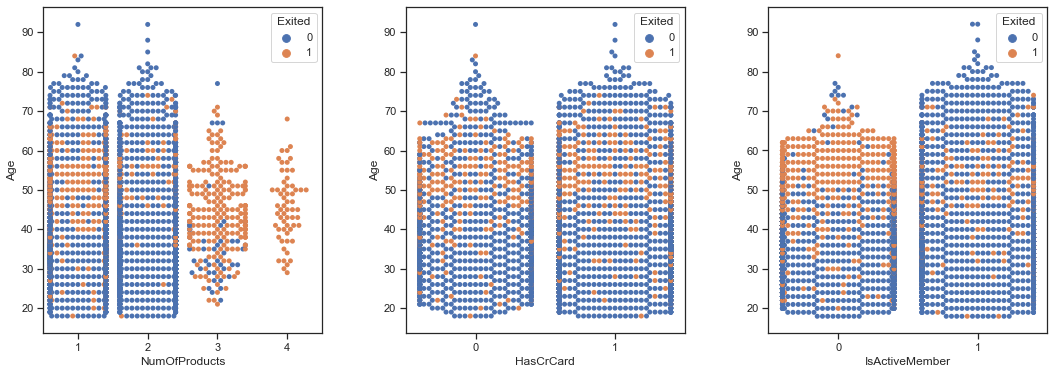

In [24]:
_, ax = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)
sns.swarmplot(x = "NumOfProducts", y = "Age", hue="Exited", data = churn, ax= ax[0])
sns.swarmplot(x = "HasCrCard", y = "Age", data = churn, hue="Exited", ax = ax[1])
sns.swarmplot(x = "IsActiveMember", y = "Age", hue="Exited", data = churn, ax = ax[2])

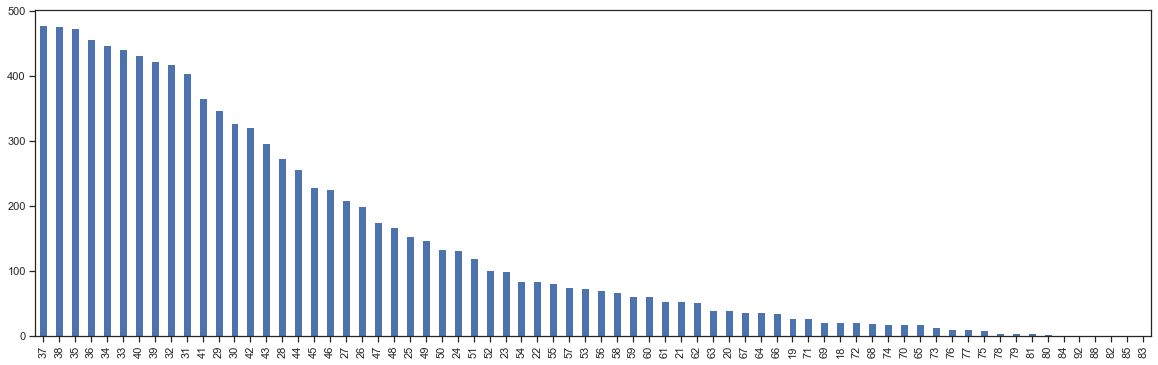

In [25]:
churn["Age"].value_counts().plot.bar(figsize=(20,6))

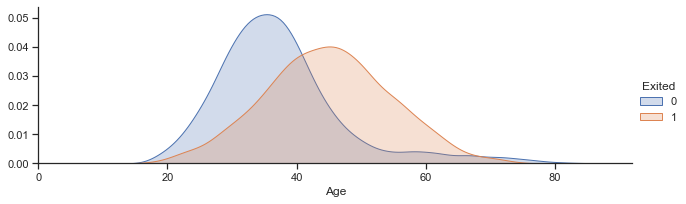

In [26]:
facet = sns.FacetGrid(churn, hue="Exited",aspect=3)
facet.map(sns.kdeplot,"Age",shade= True)
facet.set(xlim=(0, churn["Age"].max()))
facet.add_legend()

plt.show()

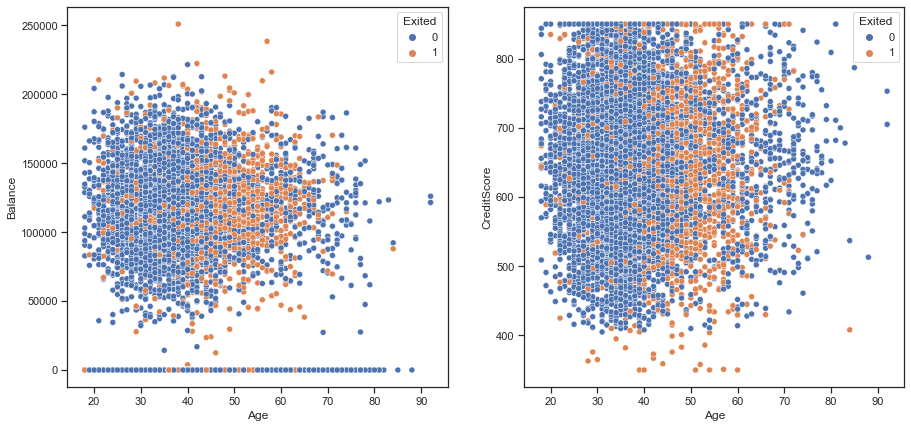

In [27]:
_, ax =  plt.subplots(1, 2, figsize=(15, 7))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.scatterplot(x = "Age", y = "Balance", hue = "Exited", cmap = cmap, sizes = (10, 200), data = churn, ax=ax[0])
sns.scatterplot(x = "Age", y = "CreditScore", hue = "Exited", cmap = cmap, sizes = (10, 200), data = churn, ax=ax[1])

- 40 to 70 years old customers are higher chances to churn

- Customer with CreditScore less then 400 are higher chances to churn

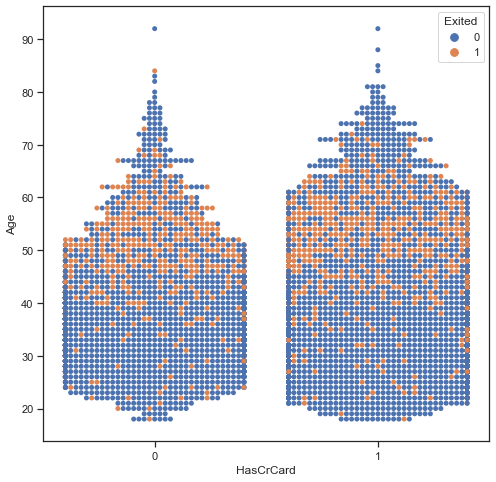

In [28]:
plt.figure(figsize=(8, 8))
sns.swarmplot(x = "HasCrCard", y = "Age", data = churn, hue="Exited")

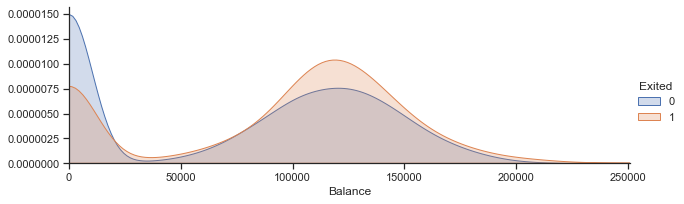

In [29]:
facet = sns.FacetGrid(churn, hue="Exited",aspect=3)
facet.map(sns.kdeplot,"Balance",shade= True)
facet.set(xlim=(0, churn["Balance"].max()))
facet.add_legend()

plt.show()

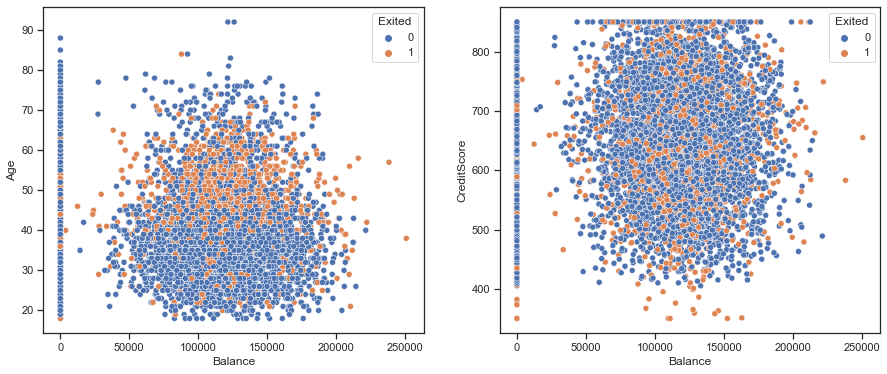

In [30]:
_, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(x = "Balance", y = "Age", data = churn, hue="Exited", ax = ax[0])
sns.scatterplot(x = "Balance", y = "CreditScore", data = churn, hue="Exited", ax = ax[1])

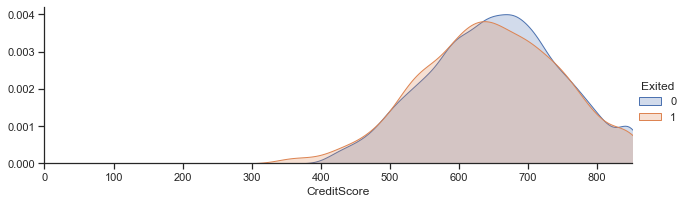

In [31]:
facet = sns.FacetGrid(churn, hue="Exited",aspect=3)
facet.map(sns.kdeplot,"CreditScore",shade= True)
facet.set(xlim=(0, churn["CreditScore"].max()))
facet.add_legend()

plt.show()

### Building Artificial Neural Network

### Data Preprocessing

In [32]:
churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [33]:
X = churn.iloc[:, :-1].values
y = churn.iloc[:, -1].values

Double check we have all the dependent varibles X

In [34]:
print(X)

[[619 'France' 'Female' ... 1 1 101348.88]
 [608 'Spain' 'Female' ... 0 1 112542.58]
 [502 'France' 'Female' ... 1 0 113931.57]
 ...
 [709 'France' 'Female' ... 0 1 42085.58]
 [772 'Germany' 'Male' ... 1 0 92888.52]
 [792 'France' 'Female' ... 1 0 38190.78]]


Double check we the dependent variable y 'Exited'

In [35]:
print(y)

[1 0 1 ... 1 1 0]


Notice we still have two categorical variables "Geography" and "Gender", we need to encode to convert categorical data, or text data, into numbers, which our predictive models can better understand.

In [36]:
# Encoding categorical data
# Label Encoding the "Gender" column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X[:, 2] = le.fit_transform(X[:, 2])
print(X)

[[619 'France' 0 ... 1 1 101348.88]
 [608 'Spain' 0 ... 0 1 112542.58]
 [502 'France' 0 ... 1 0 113931.57]
 ...
 [709 'France' 0 ... 0 1 42085.58]
 [772 'Germany' 1 ... 1 0 92888.52]
 [792 'France' 0 ... 1 0 38190.78]]


In [37]:
# One Hot Encoding the "Geography" column
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
print(X)

[[1.0 0.0 0.0 ... 1 1 101348.88]
 [0.0 0.0 1.0 ... 0 1 112542.58]
 [1.0 0.0 0.0 ... 1 0 113931.57]
 ...
 [1.0 0.0 0.0 ... 0 1 42085.58]
 [0.0 1.0 0.0 ... 1 0 92888.52]
 [1.0 0.0 0.0 ... 1 0 38190.78]]


### Splitting the dataset into the Training set and Test set

Our dataset have 20.4% on churned customers this means we will try to predict , thats why i selected to use default est_train_split model which deliver 25% test set and 75% traing set.because it covers the churned figure which prevent biases inside the model itself.

In [38]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

Feature scaling is essential for machine learning algorithms that calculate distances between data. It's a method used to normalize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step.

Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance.

In [39]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Building the ANN

### The Activation Function:

For this particular use case it was possibile to use a variety of activation functions that passes on a 'yes' or 'no' binary answer. For example, I could have used:

**Threshold Function**: basically the threshold functions are very simple; you have just you know the values from 0 to 1; if the value is less than zero then it passes on a zero. If the value is more than zero or equal to zero then threshold function passes on a one. 

So it's basically kind of like yes no type of function. Very very straightforward. Very kind of like rigid type of function either yes or no. No other options.

<br>
<div style="width: 500px;">
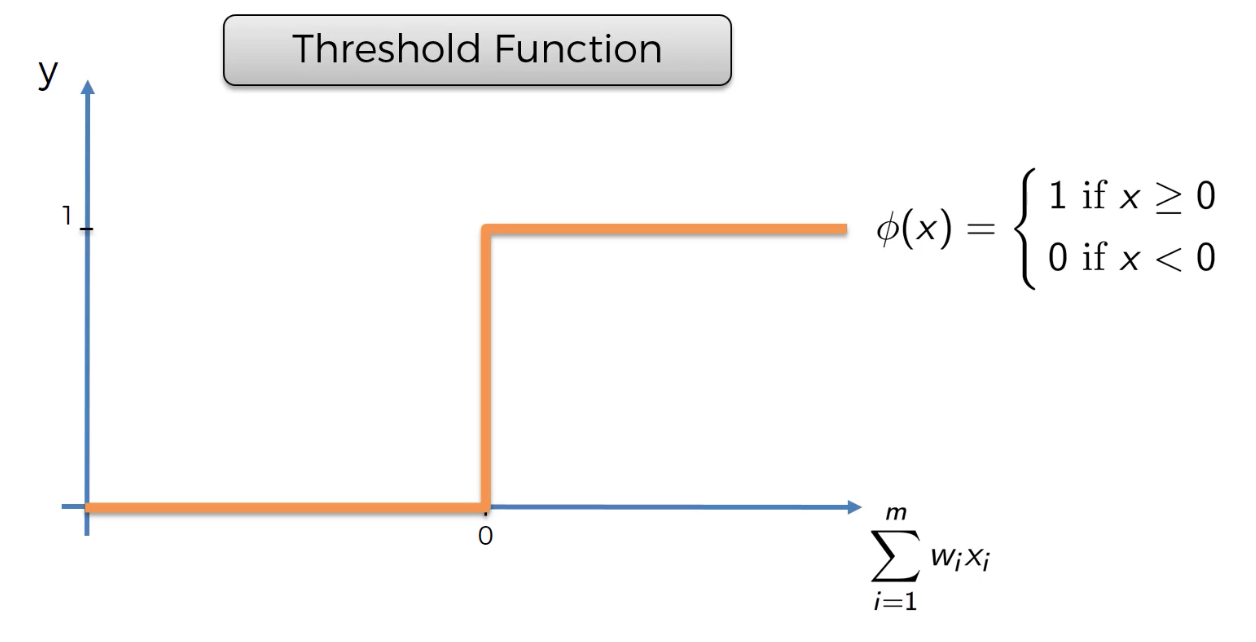
</div>
<br>

**Sigmoid Function**: It's a function which is used in the logistic regression. What is good about this function is that it is smooth.

Unlike the Threshold Function, this one doesn't have those kinks in its curve and therefore it's just nice and smooth gradual progression. So anything below 0 just drops off above zero.

It acts approximates towards one and this sigmoid function is very useful in the final output layer, especially when you're trying to predict probabilities.
<br>
<div style="width: 500px;">
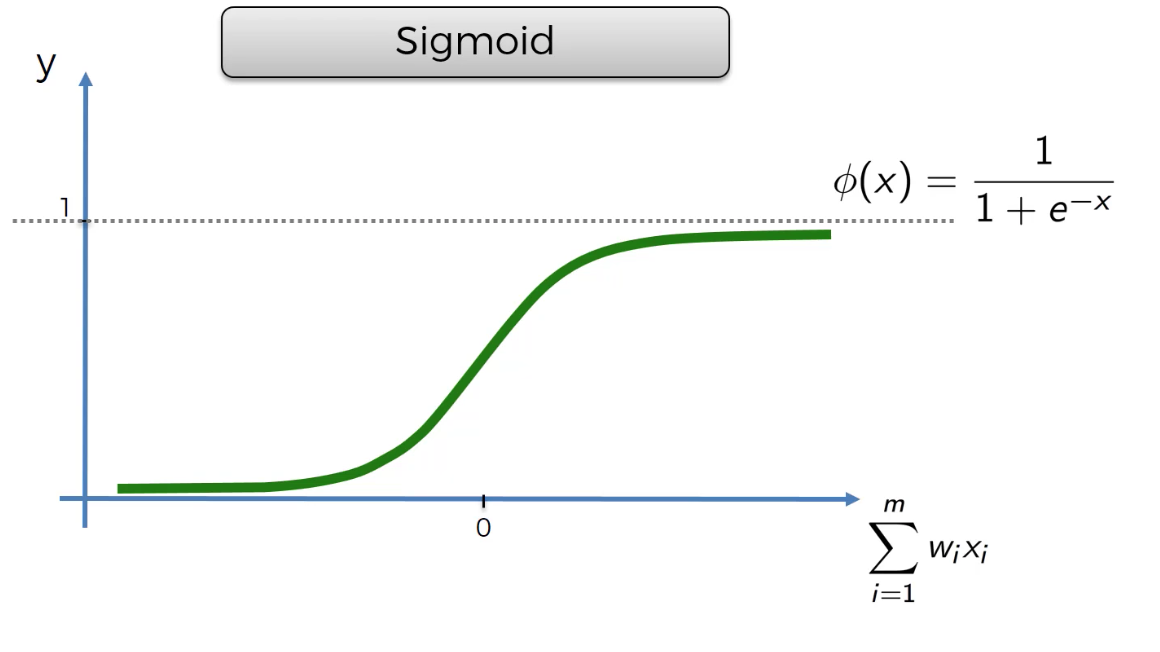
</div>
<br>


**Rectifier Function**: Though it has a kink is one of the most popular functions for artificial neural networks so it goes all the way to zero and then from there it's gradually progresses as the input value increases.

<br>
<div style="width: 500px;">
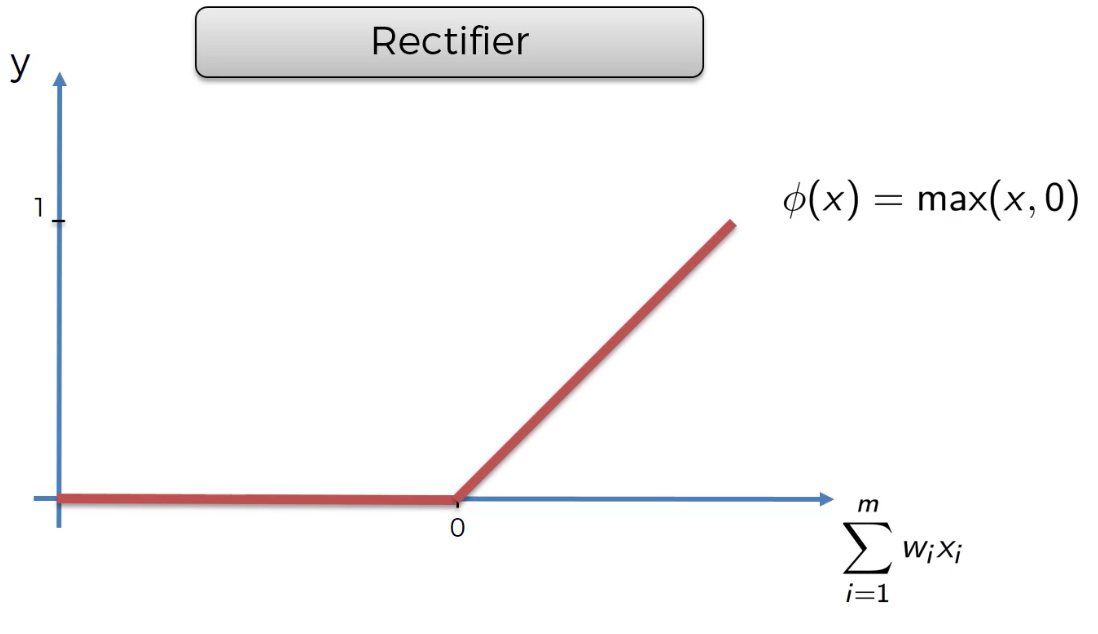
</div>
<br>

**Hyperbolic tangent function**: It's very similar to the sigmoid function but here the hyperbolic tangent function goes below zero so the values go from 0 to 1 and go from zero to minus 1 on the other side and that can be useful in some applications.

<br>
<div style="width: 600px;">
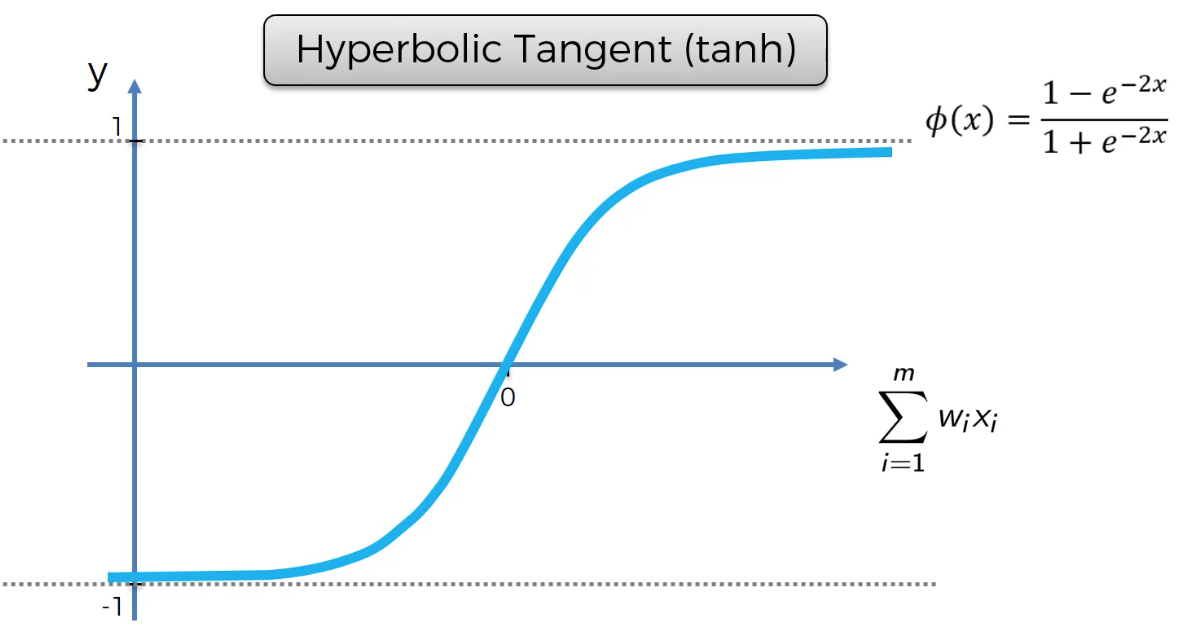
</div>
<br>


Here we are using Sigmoid Function for the output layer as we only need a '0' or '1', yes or no binary answer

In the hidden layers we are applying the Rectifier function ReLU (Rectified Linear Units). The main advantage of using the ReLU function over other activation functions is that it does not activate all the neurons at the same time. Due to this reason, during the backpropogation process, the weights and biases for some neurons are not updated. This can create dead neurons which never get activated.

It's a very common combination to use Relu and Sigmoid to produce a probabibliy of the outcome. Here's the general idea: of what we are going to do but obviously with more inputs and probably an extra hidden layer.

<br>
<div style="width: 500px;">
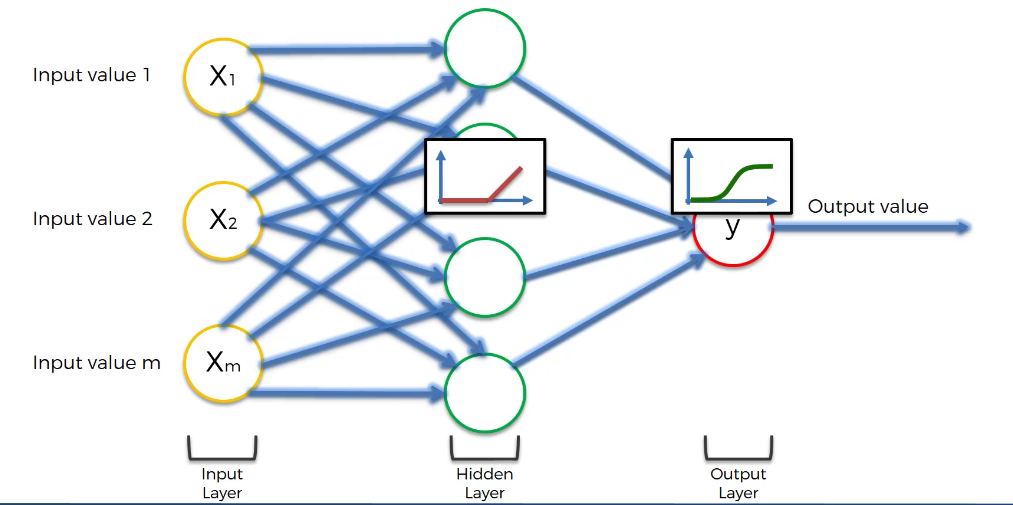
</div>
<br>


In [40]:
# Initializing the ANN
ann = tf.keras.models.Sequential()

# Adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))

# Adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))

# Adding the output layer
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


- And the first step was to initialize the ANN model as a sequence of layers.
- Then we added the input layer and the first hidden layer composed of a certain number of neurons
- Then we added the second hidden layer in order to build indeed a deep learning model as opposed to a shallow learning model.
- And then finally, we added the output layer, which will contain what we want to predict.

NOTE: Tenser Flow, which has a short 'tf' from which we're going to call a Keras Library, which is a great library to build new networks.

'Dense' layer is the regular deeply connected neural network layer. It is most common and frequently used layer. 
The output generated by the 'Dense' layer is an 'm' dimensional vector. Thus, dense layer is basically used for changing the dimensions of the vector. Dense layers also applies operations like rotation, scaling, translation on the vector.

**How many neurons?**
Part of the hyper-parameter tunning.

There isn't a definite answer here, but based on experiementation, with the number of neurons, I have chosen '6'. I choose difference numbers but got more or less the same accuracy.

### Training the ANN

- The first one is to compile the ANN with an optimizer, lost function and a metric, which will be, of course, the accuracy because we're doing some classification.

- Second step will be, of course, to train the ANN. on the training set over a certain number of epochs.

**Optimizer:** The best optimizers that can perform a gradient descent. Ny default is the **'adam'** optimizer, which is very powerful optimizer that can perform stochastic gradient descent. Which will update the weights in order to reduce the loss error between your predictions and the real results.

When we trained on the training set, we will at each iteration compare the predictions in a batch to the real results in the same batch. And the optimizer here will update the weights through stochastic gradient descent choosing Adam Optimizer to add the next iteration, hopefully to reduce the loss (the difference between the predictions and the real result).

**Accuracy:** is our final evaluation metric.

In [41]:
# Compiling the ANN
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Training the ANN on the Training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
7500/7500 [==============================] - 1s 139us/sample - loss: 0.6258 - acc: 0.6664
Epoch 2/100
7500/7500 [==============================] - 1s 73us/sample - loss: 0.4838 - acc: 0.8012
Epoch 3/100
7500/7500 [==============================] - 1s 72us/sample - loss: 0.4463 - acc: 0.8081
Epoch 4/100
7500/7500 [==============================] - 1s 77us/sample - loss: 0.4228 - acc: 0.8131
Epoch 5/100
7500/7500 [==============================] - 1s 73us/sample - loss: 0.3996 - acc: 0.8303
Epoch 6/100
7500/7500 [==============================] - 1s 73us/sample - loss: 0.3825 - acc: 0.8437
Epoch 7/100
7500/7500 [==============================] - 1s 69us/sample - loss: 0.3707 - acc: 0.8499
Epoch 8/100
7500/7500 [==============================] - 1s 70us/sample - loss: 0.3624 - acc: 0.8519
Epoch 9/100
7500/7500 [==============================] - 1s 73us/sample - loss: 0.3567 - acc: 0.8

7500/7500 [==============================] - 1s 111us/sample - loss: 0.3317 - acc: 0.8659
Epoch 78/100
7500/7500 [==============================] - 1s 87us/sample - loss: 0.3319 - acc: 0.8647
Epoch 79/100
7500/7500 [==============================] - 1s 76us/sample - loss: 0.3317 - acc: 0.8648
Epoch 80/100
7500/7500 [==============================] - 0s 65us/sample - loss: 0.3316 - acc: 0.8655
Epoch 81/100
7500/7500 [==============================] - 0s 66us/sample - loss: 0.3312 - acc: 0.8648
Epoch 82/100
7500/7500 [==============================] - 0s 66us/sample - loss: 0.3315 - acc: 0.8647
Epoch 83/100
7500/7500 [==============================] - 0s 66us/sample - loss: 0.3316 - acc: 0.8645
Epoch 84/100
7500/7500 [==============================] - ETA: 0s - loss: 0.3297 - acc: 0.865 - 1s 67us/sample - loss: 0.3313 - acc: 0.8648
Epoch 85/100
7500/7500 [==============================] - 1s 105us/sample - loss: 0.3311 - acc: 0.8648
Epoch 86/100
7500/7500 [==============================]

At 100 epochs, we are training the training set over 100 times, which shows how the accuracy is evolving and finally converges at 86.39%, or out of 100 observations we are getting 86 correct.

### Making the predictions and evaluating the model at 50% threshold

ANN model predictions are in the form of probabilities by converting are predicted probabilities which are in spread into predicted binary outcomes, zero or one.

To do this we update 'y_pred' the following way by setting it equal to the boolean result of the predicted probability if larger than 0.50%, so that if 'y_pred' is between zero and 0.5 then this new 'y_pred' will become zero = False, so that the customer will not leave the bank.

If 'y_pred' is larger than 0.5, then this will be True; the customer will leave the bank.

And that's how we get the final predicted binary outcomes, zero or one.

In [42]:
# Predicting the Test set results
y_pred = ann.predict(X_test)
y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [0 1]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


### The proper way to check our final accuracy is on the confusion matrix:

In [59]:
# # Making the Confusion Matrix
# from sklearn.metrics import confusion_matrix, accuracy_score
# cm = confusion_matrix(y_test, y_pred)

# print(cm)
# accuracy_score(y_test, y_pred)

In [54]:
### function to get confusion matrix in a proper format
def draw_cm( actual, predicted ):
    cm = confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [0,1] , yticklabels = [0,1] )
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()

Confusion Matrix


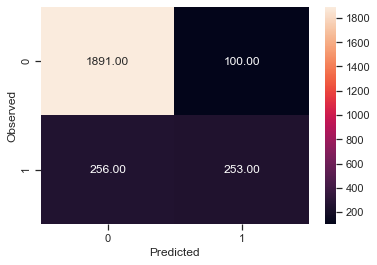

None

Accuracy Score: 0.8576

Recall: 0.49705304518664045

Precision: 0.71671388101983

F1 Score: 0.5870069605568445

Roc Auc Score: 0.7234135140548973


In [60]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)

print('Confusion Matrix')
print(draw_cm(y_test,y_pred))
print()
print("Accuracy Score:",accuracy_score(y_test, y_pred))
print()
print("Recall:",recall_score(y_test,y_pred))
print()
print("Precision:",precision_score(y_test,y_pred))
print()
print("F1 Score:",f1_score(y_test,y_pred))
print()
print("Roc Auc Score:",roc_auc_score(y_test,y_pred))

- The model is very good. We get an accuracy of over 86%.

- We correctly predicted that 1891 customer stays in the bank in the next 6 months. (True Negative)

- We correctly predicted that 253 customer left the bank in the next 6 months. (True Positive)

- And we had 100 incorrect preditions that the customer leaves the bank in the next 6 months. (False Positive)

- And we had 256 incorrect preditions that the customer stays in the bank in the next 6 months. (False Negative)


## Deploying the model on a single observation at 50% threshold

Using our ANN model to predict if the customer with the following informations will leave the bank or not in the next 6 months: 

- Geography: France
- Credit Score: 600
- Gender: Male
- Age: 40 years old
- Tenure: 3 years
- Balance: $ 60000

- Number of Products: 2
- Does this customer have a credit card? Yes
- Is this customer an Active Member: Yes
- Estimated Salary: $ 50000

So, should we say goodbye to that customer in the next 6 months?

In [44]:
# Solution: 
print(ann.predict(sc.transform([[1, 0, 0, 600, 1, 40, 3, 60000, 2, 1, 1, 50000]])) > 0.5)

[[False]]


[[False]] means that our ANN model predicts that this customer stays in the bank!

**Important note 1:** Notice that the values of the features were all input in a double pair of square brackets. That's because the "predict" method always expects a 2D array as the format of its inputs. And putting our values into a double pair of square brackets makes the input exactly a 2D array.

**Important note 2:** Notice also that the "France" country was not input as a string in the last column but as "1, 0, 0" in the first three columns. That's because of course the predict method expects the one-hot-encoded values of the state, and as we see in the first row of the matrix of features X, "France" was encoded as "1, 0, 0". And be careful to include these values in the first three columns, because the dummy variables are always created in the first columns.


## Business Insights:

From a business standpoint, the less churn the better and the more accurate we can be at predicting which attributes will contribute to a customer churning the better, but with so many features and combination of features, it is better to let the machine using artificial neural networks to work all that out and all we really want to do is input new data and it will tell whether or not a customer will churn within the next six months

#### EDA insights
From the EDA, a couple of question linger:

1) The data appears to be a snapshot as some point in time e.g. the balance is for a given date which leaves a lot of questions:
    
    What date is it and of what relevance is this date
    
    Would it be possible to obtain balances over a period of time as opposed to a single date.
    
I ask these questions because time-sequenced data plays a big part in a dataset in identifying patterns and trends especially in conjuction with marketing promotions, compeititor's marketing action, or political or economical factors.

2) There are customers who have exited but still have a balance in their account! What would this mean? Could they have exited from a product and not the bank?

3) What does being an active member mean and are there difference degrees to it? Could it be better to provide transaction count both in terms of credits and debits to the account instead?

4) A break down to the products bought into by a customer could provide more information topping listing of product count

We proceeded to the ANN model without context even though typically having context and better understanding of the data extraction process would give better insight and possibly lead to better and contextual results of the modelling process

#### Confusion matrix insights

With an accuracy rate of over 86% on the test-set (25%), we think this is a very good model, though I have tried several hyper-parameter tuning, this was the best I could achieve. I think with more data and more features, the artificial neural network would perform even better.


* Fortunatly, the False Positives are low, and the bank wouldn't any much money by predicting someone would leave when in fact they remained and the bank would have simply continued marketing to these people as normal. However, it could be argued that the bank might have spent some budget marketing to these people when it was uneccessary i.e., wasted advertising targetting the wrong type of customers.


* The model correctly predicted 253 (71.67%) left the bank (True Positives), which compared to 100 (28.33%) incorrect predictions that the customer leaves the bank in the next 6 months (False Positive), gives us quite a bit of confidence that when say a customer will leave, they will leave. The other 28.33% of the dataset will simply stay so nothing is really lost. However, we should always try to improve and focus on this part because if customers churn we will lose money more money in the long-run than marketing budget, thus it is this group we need to strive to get a high prection accuracy. 


**Hence Precision is the important metric**.

*  Precision for a class is the number of true positives (i.e. the number of customers correctly labelled as leaving the bank). This is where we stand to lose the most money

